## Time Series Prediction/Forecasting

Analyzing the dataset daily total births in California and then predicting them using baseline and ARIMA model. 

Note: This dataset doesnot have seasonality component.

In [48]:
import pandas as pd
import matplotlib as plt
%matplotlib inline

In [49]:
birth=pd.read_csv("daily-total-female-births-in-cal.csv",names=['date', 'births'],parse_dates=True,header=0,index_col=[0])

In [50]:
birth.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [51]:
birth.tail()

,births
date,
1959-12-28,52
1959-12-29,48
1959-12-30,55
1959-12-31,50
Daily total female births in California,1959


In [52]:
birth.size

366

In [44]:
birth=birth[0:365]

In [45]:
birth.index=pd.to_datetime(birth.index)

In [46]:
birth.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [7]:
birth.dtypes

births    int64
dtype: object

## Understanding the data 

In [10]:
birth.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


## Observation
The standard deviation  seems to be too high. Also the max value is quite high than than the mean value so it shows dataset has outliers. We need to remove them 

In [11]:
birth.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


## Data visualization

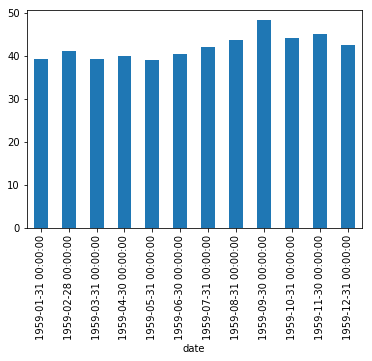

In [12]:
birth.births.resample('M').mean().plot(kind="bar")

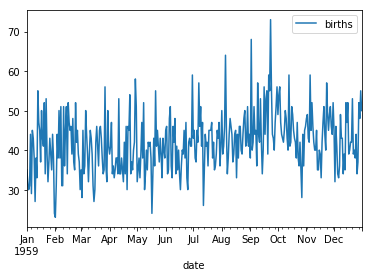

In [13]:
birth.plot()

Seems to be a stationary series i.e. no trends etc. But we will check it using adfuller test.

## Check if series is stationary via Augmented Dickey Fuller’s test 

In [14]:
#Ho: It is non stationary
#H1: It is stationary
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(birth.dropna())

ADF Test Statistic : -4.808291253559763
p-value : 5.243412990149865e-05
#Lags Used : 6
Number of Observations Used : 358
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Moving average plot
Smoothing the series

In [15]:
birth_mean=birth.rolling(window=20).mean()

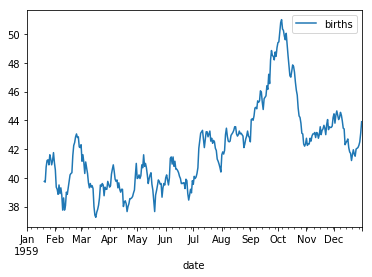

In [16]:
birth_mean.plot()

So there seems to be a spike towards the end of the curve.

## Basic Model
Let the current value be the reflection of the last value i.e. the previous value is best reflection o fthe current value.

In [17]:
birth_df=pd.concat([birth["births"],birth["births"].shift()],axis=1)

In [18]:
birth_df.columns=('Actual_birth', 'Forecasted_birth')

In [19]:
birth_df.head()

,Actual_birth,Forecasted_birth
date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0


In [20]:
birth_df.tail()

,Actual_birth,Forecasted_birth
date,,
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0
1959-12-30,55,48.0
1959-12-31,50,55.0


In [21]:
birth_df=birth_df[1:364]

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np
birth_error=mean_squared_error(birth_df.Actual_birth,birth_df.Forecasted_birth)

In [23]:
birth_error

84.38567493112947

In [24]:
np.sqrt(birth_error)

9.186167586710438

 So the basic model gives an error of +- 9 births error. (Close to standard deviation of 7). Now trying out advance models, hoping their error should be less than this basic model error

## Applying ARIMA model
Autoregressive Integrated Moving Average. 

It needs (p,d,q)

where:
p: Trend autoregression order (AR)

d: Trend difference order.i.e. difference to make the time series data stationary by removing trend or seasonality component

q: Trend moving average order (MA)

Since we know that the data is stationary. Hence the value of “d” can be zero (d=0) 

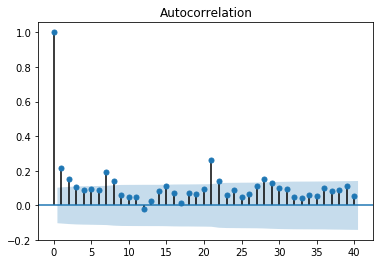

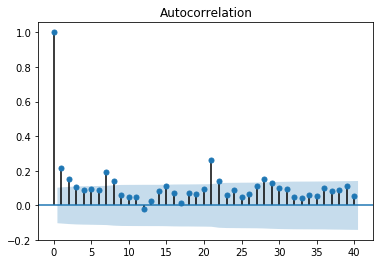

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#plot_acf gives q values
#plot_pacf for p values
# d if stationary=0, if little variations say 1

# ARIMA needs order=(p,d,q)
plot_acf(birth,lags=40)
# so q=3,4

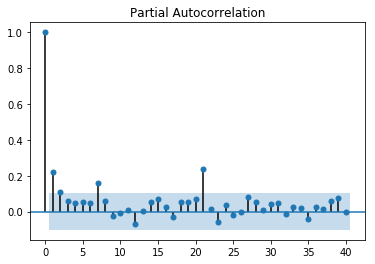

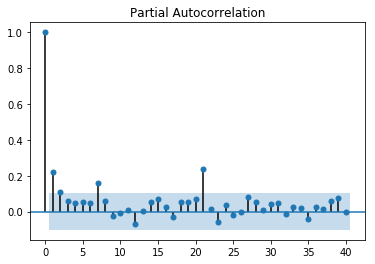

In [26]:
plot_pacf(birth,lags=40)

#so  p =2,3,4

# First Attempt( ARIMA(2,1,3))

In [134]:
birth_train=birth[1:330]
birth_test=birth[330:365]

In [135]:
from statsmodels.tsa.arima_model import ARIMA
birth_model= ARIMA(birth_train.values,order=(2,1,3))
model_fit=birth_model.fit()
model_fit.aic # Lesser the aic, better the model

2225.0043307130577

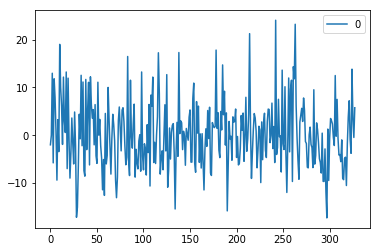

In [136]:
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

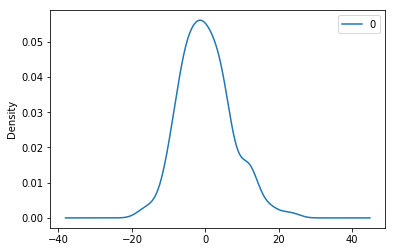

In [137]:
residuals.plot(kind='kde')

So mostly values are around normal, just a bit skewed towards right.

In [138]:
residuals.describe()

,0
count,328.000000
mean,0.145670
std,7.051325
min,-17.351026
25%,-4.829319
50%,-0.402334
75%,4.359124
max,24.104555


Residual Mean is not exactly zero but very close to it. So, model seems to be quite good.

In [141]:
birth_forecast=model_fit.forecast(steps=35)[0]
np.sqrt(mean_squared_error(birth_forecast,birth_test))

6.855638208734547

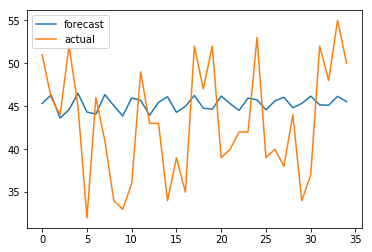

In [142]:
df=pd.DataFrame()
df['forecast']=birth_forecast
df['actual']=birth_test['births'].values
df[['forecast','actual']].plot()

## Find best aic value using autoarima

In [143]:
from pmdarima.arima import auto_arima
model = auto_arima(birth_train.values, trace=True, error_action='ignore', suppress_warnings=True,stationary=True)
model.fit(birth)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=2236.866, BIC=2259.642, Time=0.533 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=2255.635, BIC=2263.227, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=2242.827, BIC=2254.215, Time=0.036 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=2245.748, BIC=2257.136, Time=0.081 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=3403.425, BIC=3407.221, Time=0.006 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=2235.733, BIC=2254.714, Time=0.468 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=2243.039, BIC=2258.223, Time=0.119 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=2234.940, BIC=2250.125, Time=0.324 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=2237.231, BIC=2256.211, Time=0.361 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=2240.253, BIC=2255.437, Time=0.083 seconds
Total fit time: 2.021 seconds


ARIMA(order=(1, 0, 1), suppress_warnings=True)

# Second attempt: ARIMA(1,0,1)

In [144]:
from statsmodels.tsa.arima_model import ARIMA
birth_model= ARIMA(birth_train.values,order=(1,0,1))
model_fit=birth_model.fit()
model_fit.aic # Lesser the aic, better the model

2230.5688939120546

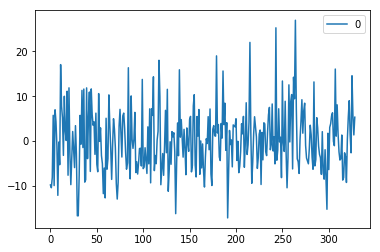

In [145]:
residuals=pd.DataFrame(model_fit.resid)
residuals.plot()

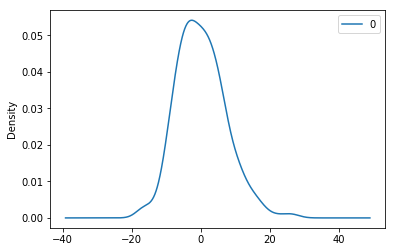

In [146]:
residuals.plot(kind='kde')

In [147]:
residuals.describe()

,0
count,329.000000
mean,0.170139
std,7.102049
min,-17.122634
25%,-5.026370
50%,-0.277381
75%,4.398982
max,26.931796


In [148]:
birth_forecast=model_fit.forecast(steps=35)[0]
np.sqrt(mean_squared_error(birth_forecast,birth_test))

6.570766890324744

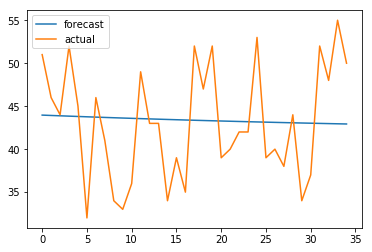

In [149]:
df=pd.DataFrame()
df['forecast']=birth_forecast
df['actual']=birth_test['births'].values
df[['forecast','actual']].plot()

In [150]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  329
Model:                     ARMA(1, 1)   Log Likelihood               -1111.284
Method:                       css-mle   S.D. of innovations              7.086
Date:                Tue, 21 Jul 2020   AIC                           2230.569
Time:                        13:42:03   BIC                           2245.753
Sample:                             0   HQIC                          2236.626
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7932      1.476     28.320      0.000      38.901      44.686
ar.L1.y        0.9812      0.024     41.731      0.000       0.935       1.027
ma.L1.y       -0.9207      0.056    -16.587      0.0

## Results
So we got an error of +-6.5 births when we forecasted values using ARIMA model.